# MIMIC-III Hospital Mortality Classification Pipeline
## Mariajosé Argote - Computational Machine Learning Final Project

---

### Project Overview

This notebook builds a **binary classification** pipeline to predict `HOSPITAL_EXPIRE_FLAG` (patient mortality during ICU stay).

**Dataset:** 20,885 ICU observations  
**Target:** 0 = survived, 1 = died  

**Visual Inspection**
* 10% of heart rate and blood pressure columns are missing / blank
* 11% of SYS and DiasBP columns are missing /blank
* 10% missing respiration rate columns
* 12% missing temperature information
* 11% missing SPO2 columns information

**Pipeline:**
1. EDA & Data Cleaning
2. Feature Engineering (age, diagnosis severity)
3. Preprocessing (imputation, encoding, scaling)
4. Model Training (Logistic, RF, XGBoost)
5. Predictions & CSV Export


## 1. Setup & Configuration


In [367]:
# Configuration
EDA = True  # Set to False to skip visualizations
SEED = 244459055  # For reproducibility
ALPHA = 9 #tweak for severity calculation, 9 appears to be optimal


In [368]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

# Sklearn - CLASSIFICATION (not regression!)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("⚠️  XGBoost not available")

# Settings

np.random.seed(SEED)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries imported")
print(f"✓ Random seed: {SEED}")
print(f"✓ XGBoost available: {HAS_XGB}")


✓ Libraries imported
✓ Random seed: 244459055
✓ XGBoost available: True


## 2. Data Loading & Column Definitions


In [369]:
# Load datasets
train = pd.read_csv('MIMIC III dataset HEF/mimic_train_HEF.csv')
test= pd.read_csv('MIMIC III dataset HEF/mimic_test_HEF.csv')
MIMIC_diagnoses = pd.read_csv('MIMIC III dataset HEF/extra_data/MIMIC_diagnoses.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Diagnoses shape: {MIMIC_diagnoses.shape}")

train.head()


Train shape: (20885, 44)
Test shape: (5221, 39)
Diagnoses shape: (651047, 4)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2180-03-09 00:00:00,2178-02-06 10:35:00,2178-02-13 18:30:00,NaN,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,NaN,2129-02-12 22:34:00,2129-02-13 16:20:00,NaN,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,NaN,2125-11-17 23:04:00,2125-12-05 17:55:00,NaN,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2132-03-01 00:00:00,2131-01-26 08:00:00,2131-02-05 16:23:00,NaN,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,2066-12-19 00:00:00,2147-01-18 00:00:00,2146-05-04 02:02:00,2146-05-20 18:40:00,NaN,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [370]:
# Define column groups
target_col = 'HOSPITAL_EXPIRE_FLAG'
id_cols = ['subject_id', 'hadm_id', 'icustay_id']
leaky_cols = ['LOS', 'DOD', 'DISCHTIME', 'DEATHTIME']  # Must drop - reveal outcome!!!

# Vital signs (24 features: min/max/mean for 8 vitals)
vital_cols = [
    'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
    'SysBP_Min', 'SysBP_Max', 'SysBP_Mean',
    'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
    'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
    'RespRate_Min', 'RespRate_Max', 'RespRate_Mean',
    'TempC_Min', 'TempC_Max', 'TempC_Mean',
    'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
    'Glucose_Min', 'Glucose_Max', 'Glucose_Mean'
]

# Demographics
demographic_cols = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 
                   'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']

# Clinical
clinical_cols = ['DIAGNOSIS', 'ICD9_diagnosis', 'FIRST_CAREUNIT']

print(f"✓ Column groups defined:")
print(f"  - Vitals: {len(vital_cols)}")
print(f"  - Demographics: {len(demographic_cols)}")
print(f"  - Clinical: {len(clinical_cols)}")


✓ Column groups defined:
  - Vitals: 24
  - Demographics: 6
  - Clinical: 3


## 3. Exploratory Data Analysis

Intuition and analyzing data quality, distributions, and relationships with mortality.


### 3.1 Missing Data Analysis


In [371]:
# Create working copies without leakage columns
train_model = train.drop(columns=leaky_cols, errors='ignore')
test_model = test.drop(columns=leaky_cols, errors='ignore')

print(f"Working shapes (after dropping leakage cols):")
print(f"  Train: {train_model.shape}")
print(f"  Test: {test_model.shape}")


Working shapes (after dropping leakage cols):
  Train: (20885, 40)
  Test: (5221, 39)


In [372]:
# Function to summarize missing values
def missing_summary(df):
    """Calculate missing value statistics per column"""
    n = len(df)
    miss_cnt = df.isna().sum()
    miss_pct = miss_cnt / n
    return (
        pd.DataFrame({
            'n_missing': miss_cnt,
            'pct_missing': miss_pct
        })
        .sort_values('pct_missing', ascending=False)
    )

# Check missing values
col_missing = missing_summary(train_model.drop(columns=id_cols, errors='ignore'))
print(" TOP 15 COLUMNS WITH MISSING VALUES ")
print(col_missing.head(15))

# Row-wise missing
row_missing_count = train_model.isna().sum(axis=1)
row_missing_frac = row_missing_count / train_model.shape[1]

print(f"\n=== ROW-WISE MISSING DATA ===")
print(f"Rows with ANY missing: {(row_missing_count > 0).mean():.1%}")
print(f"Rows with >20% missing: {(row_missing_frac > 0.2).mean():.1%}")
print(f"Rows with >50% missing: {(row_missing_frac > 0.5).mean():.1%}")


 TOP 15 COLUMNS WITH MISSING VALUES 
               n_missing  pct_missing
TempC_Max           2497     0.119559
TempC_Mean          2497     0.119559
TempC_Min           2497     0.119559
DiasBP_Max          2209     0.105770
DiasBP_Mean         2209     0.105770
DiasBP_Min          2209     0.105770
SysBP_Min           2208     0.105722
SysBP_Max           2208     0.105722
SysBP_Mean          2208     0.105722
SpO2_Max            2203     0.105482
SpO2_Min            2203     0.105482
SpO2_Mean           2203     0.105482
RespRate_Min        2189     0.104812
RespRate_Max        2189     0.104812
RespRate_Mean       2189     0.104812

=== ROW-WISE MISSING DATA ===
Rows with ANY missing: 16.3%
Rows with >20% missing: 10.5%
Rows with >50% missing: 10.5%


Comment: ~10% of rows have missing vitals. to explore.

In [373]:
#check if vital signs are missing together in rows

vital_cols_present = [c for c in vital_cols if c in train_model.columns] 

missing_vitals = train_model[vital_cols_present].isna()

# Fraction of rows with at least one missing vital
rows_any_vital_missing  = missing_vitals.any(axis=1)
# Fraction of rows with all vitals missing
rows_all_vitals_missing = missing_vitals.all(axis=1)

print("=== VITAL SIGNS MISSINGNESS PATTERN ===")
print(f"Rows with ANY vital missing: {rows_any_vital_missing.mean():.1%}")
print(f"Rows with ALL vitals missing: {rows_all_vitals_missing.mean():.1%}")

# See patterns of missingness across vitals
pattern_counts = missing_vitals.value_counts()
print(pattern_counts.head(10))

=== VITAL SIGNS MISSINGNESS PATTERN ===
Rows with ANY vital missing: 13.3%
Rows with ALL vitals missing: 0.0%
HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  MeanBP_Max  MeanBP_Mean  RespRate_Min  RespRate_Max  RespRate_Mean  TempC_Min  TempC_Max  TempC_Mean  SpO2_Min  SpO2_Max  SpO2_Mean  Glucose_Min  Glucose_Max  Glucose_Mean
False          False          False           False      False      False       False       False       False        False       False       False        False         False         False          False      False      False       False     False     False      False        False        False           18113
True           True           True            True       True       True        True        True        True         True        True        True         True          True          True           True       True       True        True      True      True       False        Fals

In [374]:
# Looks like some rows are missing all vitals except glucose

vital_cols_w_glucose = [c for c in vital_cols_present if 'Glucose' not in c]

missing_vitals = train_model[vital_cols_present].isna()
rows_any_vital_missing = missing_vitals.any(axis=1)
rows_all_vitals_missing = missing_vitals.all(axis=1)


# Count missing vitals per row
n_vitals_missing = train_model[vital_cols_w_glucose].isna().sum(axis=1)
n_extreme = (n_vitals_missing == 21).sum()
print(f"\nRows with 21/21 non-glucose vitals missing: {n_extreme} ({n_extreme/len(train_model):.1%})")



Rows with 21/21 non-glucose vitals missing: 2183 (10.5%)


### 3.2 Data Cleaning Decision




In [375]:
# Drop rows with extreme vital missingness
train_model_clean = train_model.dropna(subset=vital_cols_w_glucose, thresh=1)
test_model_clean = test_model.dropna(subset=vital_cols_w_glucose, thresh=1)

print(f"=== DATA CLEANING RESULTS ===")
print(f"Original train size: {len(train_model):,}")
print(f"Cleaned train size:  {len(train_model_clean):,}")
print(f"Rows dropped: {len(train_model) - len(train_model_clean):,} ({(1 - len(train_model_clean)/len(train_model)):.1%})")

# Check bias
dropped_mask = ~train_model.index.isin(train_model_clean.index)
mort_dropped = train_model.loc[dropped_mask, target_col].mean()
mort_kept = train_model_clean[target_col].mean()

print(f"\nMortality rate in DROPPED rows: {mort_dropped:.3f}")
print(f"Mortality rate in KEPT rows:    {mort_kept:.3f}")
print(f"→ No significant bias introduced")


=== DATA CLEANING RESULTS ===
Original train size: 20,885
Cleaned train size:  18,702
Rows dropped: 2,183 (10.5%)

Mortality rate in DROPPED rows: 0.113
Mortality rate in KEPT rows:    0.112
→ No significant bias introduced

Original train size: 20,885
Cleaned train size:  18,702
Rows dropped: 2,183 (10.5%)

Mortality rate in DROPPED rows: 0.113
Mortality rate in KEPT rows:    0.112
→ No significant bias introduced


**Decision:** Remove ICU stays where ≥87.5% of vital signs are missing (21 out of 24 features).

**Rationale:**
- Vital signs are core predictors for mortality
- 2,183 rows (10.5%) have this extreme missingness
- For remaining patients, missing values can be imputed

### 3.3 Target Distribution


=== TARGET DISTRIBUTION ===
HOSPITAL_EXPIRE_FLAG
0    0.887819
1    0.112181
Name: proportion, dtype: float64


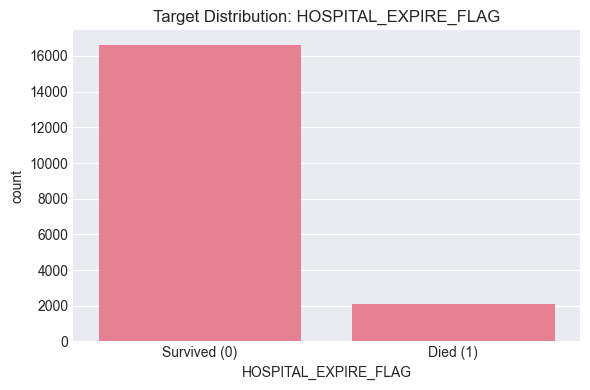

In [376]:
# Check class balance
print("=== TARGET DISTRIBUTION ===")
print(train_model_clean[target_col].value_counts(normalize=True))

if EDA:
    plt.figure(figsize=(6,4))
    sns.countplot(x=target_col, data=train_model_clean)
    plt.title('Target Distribution: HOSPITAL_EXPIRE_FLAG')
    plt.xticks([0, 1], ['Survived (0)', 'Died (1)'])
    plt.tight_layout()
    plt.show()


### 3.4 Vital Signs Analysis


In [377]:
# Analyze vital means
vital_means = [c for c in vital_cols if c.endswith('_Mean') and c in train_model_clean.columns]

print("=== VITAL SIGNS SUMMARY ===")
print(train_model_clean[vital_means].describe())

# Mean vitals by survival outcome
print("\n=== MEAN VITALS BY OUTCOME ===")
grouped_vitals = train_model_clean.groupby(target_col)[vital_means].mean().T
grouped_vitals.columns = ['Survived', 'Died']
print(grouped_vitals)


=== VITAL SIGNS SUMMARY ===
       HeartRate_Mean    SysBP_Mean   DiasBP_Mean   MeanBP_Mean  \
count    18698.000000  18677.000000  18676.000000  18699.000000   
mean        85.180250    119.145423     62.511614     77.609535   
std         15.318208     16.701503     11.010790     11.113299   
min         34.714286     46.000000     17.000000     25.759907   
25%         74.272727    107.100000     54.950952     70.033908   
50%         84.131183    116.901961     61.423660     76.294118   
75%         95.185588    129.465116     68.954545     84.041774   
max        163.875000    202.172414    121.489362    136.652174   

       RespRate_Mean    TempC_Mean     SpO2_Mean  Glucose_Mean  
count   18696.000000  18388.000000  18682.000000  18449.000000  
mean       18.985855     36.751717     96.866685    139.033918  
std         3.849713      0.603476      2.333108     44.437267  
min         9.291667     30.666667     47.666667     43.250000  
25%        16.250000     36.388889     95.8

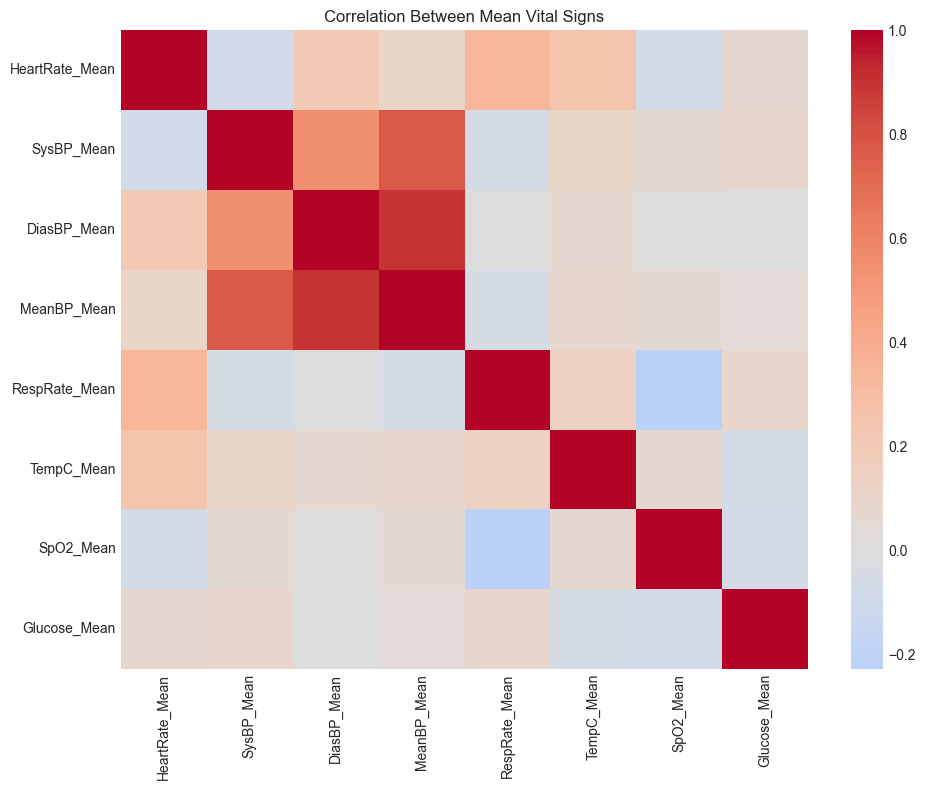

In [378]:
# Correlation matrix
if EDA:
    corr = train_model_clean[vital_means].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation Between Mean Vital Signs')
    plt.tight_layout()
    plt.show()


# Only did mean as the vitals come in sets of min/max/mean and mean is
# representative enough for EDA purposes correlations

Observations:
* Heart rate and respiration rate are moderately positively correlated
* Systolic, Diastolic BP and MeanBP are highly correlated, as expected
* SpO2 and Respiratory Rate are negatively correlated, as expected
* Heart rate and Respiration Rate and TempC are positively correlated
* Glucose is negatively correlated with Temperature and SpO2

## 4. Feature Engineering


### 4.1 Age Calculation


In [379]:
# Function to add age and time features
def add_age_and_time_features(df):
    """Calculate age and temporal features"""
    df = df.copy()
    
    # Convert to datetime
    df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
    df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'], errors='coerce')
    
    # Calculate age
    df['AGE'] = np.nan
    valid_mask = df['DOB'].notna() & df['ADMITTIME'].notna()
    
    if valid_mask.any():
        dob = df.loc[valid_mask, 'DOB']
        admit = df.loc[valid_mask, 'ADMITTIME']
        
        years = admit.dt.year - dob.dt.year
        had_birthday = (
            (admit.dt.month > dob.dt.month) |
            ((admit.dt.month == dob.dt.month) & (admit.dt.day >= dob.dt.day))
        )
        age_years = years - (~had_birthday).astype(int)
        df.loc[valid_mask, 'AGE'] = age_years
        
        # Clamp to [0, 120]
        invalid_mask = (df['AGE'] < 0) | (df['AGE'] > 120)
        df.loc[invalid_mask, 'AGE'] = np.nan
    
    # Temporal features
    df['admit_hour'] = df['ADMITTIME'].dt.hour
    df['admit_weekday'] = df['ADMITTIME'].dt.dayofweek
    df['is_weekend'] = df['admit_weekday'].isin([5, 6]).astype(int)
    
    return df

print("✓ Age feature function defined")


✓ Age feature function defined


Train shape with age features: (18702, 44)

Age statistics:
count    17710.000000
mean        62.228120
std         16.429028
min         15.000000
25%         52.000000
50%         64.000000
75%         75.000000
max         89.000000
Name: AGE, dtype: float64


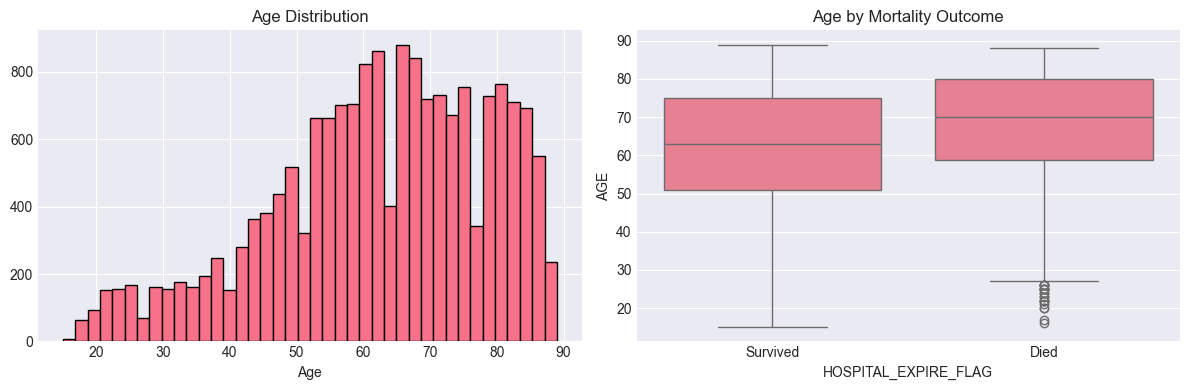

In [380]:
# Apply to training data
train_base = add_age_and_time_features(train_model_clean)

print(f"Train shape with age features: {train_base.shape}")
print(f"\nAge statistics:")
print(train_base['AGE'].describe())

if EDA:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.hist(train_base['AGE'].dropna(), bins=40, edgecolor='black')
    ax1.set_title('Age Distribution')
    ax1.set_xlabel('Age')
    
    sns.boxplot(x=target_col, y='AGE', data=train_base, ax=ax2)
    ax2.set_title('Age by Mortality Outcome')
    ax2.set_xticklabels(['Survived', 'Died'])
    
    plt.tight_layout()
    plt.show()

   


### 4.2 Diagnosis Severity Features

**Severity** = mortality risk score per ICD9 diagnosis code

**How it's calculated:**
1. For each ICD9 code in the training data, compute the proportion of patients who died
2. Apply Bayesian smoothing to balance observed rates with the overall mortality rate
3. Rare diagnoses (few patients) shrink toward the average; common diagnoses stay close to observed rates
4. severity = (n × raw_mort + α × overall_mort) / (n + α) where α = 10 prevents overfitting on rare diagnoses

**Why Bayesian smoothing?**
- Prevents extreme estimates: A rare code with 1 patient who died would have raw mortality = 100%, which is unreliable. With smoothing (α=10), that becomes: (1 × 1.0 + 10 × 0.112) / 11 ≈ 0.19 (more conservative). Common codes with 100+ patients are barely affected by the prior

**α = 10 interpretation:**
- Acts like adding 10 "virtual patients" with average mortality to every ICD9 code
- Balances between observed data (for common codes) and prior knowledge (for rare codes)
- it is a hyperparameter!

Each ICD9 code gets a severity score between 0 (low mortality risk) and 1 (high mortality risk)

This allows me to create 4 new features from the external diagnoses data:
- `diagnosis_count`: Total diagnoses per patient
- `avg_diagnosis_severity`: Mean mortality rate across diagnoses  
- `max_diagnosis_severity`: Highest risk diagnosis
- `primary_diagnosis_severity`: Primary diagnosis mortality rate




In [381]:
# Function to fit diagnosis features (training only)
def fit_diagnosis_features(train_df, diagnoses_df):
    """Fit diagnosis severity features on training data"""
    df = train_df.copy()
    
    # Restrict to training admissions
    diagnoses_train = diagnoses_df[diagnoses_df['HADM_ID'].isin(df['hadm_id'])].copy()
    
    # Merge labels
    diagnoses_train = diagnoses_train.merge(
        df[['hadm_id', target_col]],
        left_on='HADM_ID',
        right_on='hadm_id',
        how='left'
    )
    
    # Count diagnoses per admission
    diag_counts = diagnoses_train.groupby('hadm_id').size().reset_index(name='diagnosis_count')
    
    # Calculate severity per ICD9 code (Bayesian smoothed)
    severity_stats = (
        diagnoses_train
        .groupby('ICD9_CODE')[target_col]
        .agg(['sum', 'count'])
        .rename(columns={'sum': 'n_deaths', 'count': 'n_patients'})
    )
    
    overall_mort = df[target_col].mean()
    alpha = ALPHA  # Bayesian smoothing hyperparameter up top!
    
    severity_stats['severity'] = (
        (severity_stats['n_deaths'] + alpha * overall_mort) /
        (severity_stats['n_patients'] + alpha)
    )
    
    severity_map = severity_stats['severity'].to_dict()
    
    # Add severity to diagnoses
    diagnoses_train['severity'] = diagnoses_train['ICD9_CODE'].map(severity_map)
    
    # Aggregate severity features
    severity_agg = diagnoses_train.groupby('hadm_id')['severity'].agg([
        ('avg_diagnosis_severity', 'mean'),
        ('max_diagnosis_severity', 'max')
    ]).reset_index()
    
    # Primary diagnosis severity
    primary = diagnoses_train[diagnoses_train['SEQ_NUM'] == 1][['hadm_id', 'severity']]
    primary = primary.rename(columns={'severity': 'primary_diagnosis_severity'})
    
    # Merge all diagnosis features
    df = df.merge(diag_counts, on='hadm_id', how='left')
    df = df.merge(severity_agg, on='hadm_id', how='left')
    df = df.merge(primary, on='hadm_id', how='left')
    
    # Fill missing
    df['diagnosis_count'] = df['diagnosis_count'].fillna(0)
    for col in ['avg_diagnosis_severity', 'max_diagnosis_severity', 'primary_diagnosis_severity']:
        df[col] = df[col].fillna(overall_mort)
    
    # Save state for test set
    state = {
        'severity_map': severity_map,
        'overall_mort': overall_mort,
        'alpha': alpha
    }
    
    return df, state

print("✓ Diagnosis feature functions defined")


✓ Diagnosis feature functions defined


In [382]:
# Function to apply diagnosis features (test set)
def apply_diagnosis_features(test_df, diagnoses_df, state):
    """Apply fitted diagnosis features to test data"""
    df = test_df.copy()
    
    diagnoses_test = diagnoses_df[diagnoses_df['HADM_ID'].isin(df['hadm_id'])].copy()
    
    # Count
    diag_counts = diagnoses_test.groupby('HADM_ID').size().reset_index(name='diagnosis_count')
    diag_counts = diag_counts.rename(columns={'HADM_ID': 'hadm_id'})
    
    # Apply saved severity map
    diagnoses_test['severity'] = diagnoses_test['ICD9_CODE'].map(state['severity_map'])
    diagnoses_test['severity'] = diagnoses_test['severity'].fillna(state['overall_mort'])
    
    # Aggregate
    severity_agg = diagnoses_test.groupby('HADM_ID')['severity'].agg([
        ('avg_diagnosis_severity', 'mean'),
        ('max_diagnosis_severity', 'max')
    ]).reset_index().rename(columns={'HADM_ID': 'hadm_id'})
    
    primary = diagnoses_test[diagnoses_test['SEQ_NUM'] == 1][['HADM_ID', 'severity']]
    primary = primary.rename(columns={'HADM_ID': 'hadm_id', 'severity': 'primary_diagnosis_severity'})
    
    # Merge
    df = df.merge(diag_counts, on='hadm_id', how='left')
    df = df.merge(severity_agg, on='hadm_id', how='left')
    df = df.merge(primary, on='hadm_id', how='left')
    
    # Fill missing
    df['diagnosis_count'] = df['diagnosis_count'].fillna(0)
    for col in ['avg_diagnosis_severity', 'max_diagnosis_severity', 'primary_diagnosis_severity']:
        df[col] = df[col].fillna(state['overall_mort'])
    
    return df

print("✓ Apply diagnosis features function defined")


✓ Apply diagnosis features function defined


In [383]:
# Fit on training data
train_base_w_severity, diag_state = fit_diagnosis_features(train_base, MIMIC_diagnoses)

print(f"\n✓ Diagnosis features added to training data")
print(f"  New features: diagnosis_count, avg/max/primary_diagnosis_severity")
print(f"\nDiagnosis feature statistics:")
diag_feat_cols = ['diagnosis_count', 'avg_diagnosis_severity', 'max_diagnosis_severity', 'primary_diagnosis_severity']
print(train_base_w_severity[diag_feat_cols].describe())

# Save state
joblib.dump(diag_state, 'diagnosis_state.pkl')
print("\n✓ Diagnosis state saved for test set")



✓ Diagnosis features added to training data
  New features: diagnosis_count, avg/max/primary_diagnosis_severity

Diagnosis feature statistics:
       diagnosis_count  avg_diagnosis_severity  max_diagnosis_severity  \
count     21006.000000            21006.000000            21006.000000   
mean         22.142531                0.138623                0.291864   
std          22.026293                0.039094                0.131673   
min           1.000000                0.020457                0.020457   
25%          10.000000                0.110915                0.194413   
50%          16.000000                0.131764                0.263724   
75%          24.000000                0.160360                0.356822   
max         195.000000                0.406342                0.733654   

       primary_diagnosis_severity  
count                21006.000000  
mean                     0.157483  
std                      0.092580  
min                      0.016551  
25%      

## 5. Preprocessing Pipeline


### 5.1 Fit Preprocessing on Training Data

**Steps:**
1. Impute missing values (median for vitals, mode for categoricals)
2. One-hot encode categorical variables
3. Scale numerical features (StandardScaler)
4. Save fitted transformers for test set


In [384]:
def fit_preprocessing_pipeline(df, target_col):
    """Fit all preprocessing transformers on training data"""
    df = df.copy()
    
    print("=== FITTING PREPROCESSING PIPELINE ===\n")
    
    # Drop leaky and ID columns
    cols_to_drop = id_cols + leaky_cols + ['DOB', 'ADMITTIME', 'DISCHTIME', 'Diff',
                                           'DIAGNOSIS', 'ICD9_diagnosis']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')
    
    # Separate target
    y = df[target_col]
    X = df.drop(columns=[target_col])
    
    # Identify feature types
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Features: {len(X.columns)} total")
    print(f"  - Categorical: {len(cat_cols)}")
    print(f"  - Numerical: {len(num_cols)}")
    
    # Impute missing values
    imputer_vitals = SimpleImputer(strategy='median')
    imputer_cats = SimpleImputer(strategy='most_frequent')
    
    vital_cols_in_X = [c for c in vital_cols if c in num_cols]
    other_num_cols = [c for c in num_cols if c not in vital_cols]
    
    if vital_cols_in_X:
        X[vital_cols_in_X] = imputer_vitals.fit_transform(X[vital_cols_in_X])
    if other_num_cols:
        X[other_num_cols] = X[other_num_cols].fillna(X[other_num_cols].median())
    if cat_cols:
        X[cat_cols] = imputer_cats.fit_transform(X[cat_cols])
    
    print(f"\n✓ Imputed missing values")
    
    # One-hot encode categoricals
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True, dtype=int)
        print(f"✓ Encoded {len(cat_cols)} categorical variables")
    
    # Scale numerical features
    num_to_scale = [c for c in X.columns if X[c].dtype in [np.float64, np.int64]]
    scaler = StandardScaler()
    X[num_to_scale] = scaler.fit_transform(X[num_to_scale])
    print(f"✓ Scaled {len(num_to_scale)} numerical features")
    
    # Save state
    state = {
        'imputer_vitals': imputer_vitals,
        'imputer_cats': imputer_cats,
        'scaler': scaler,
        'cat_cols': cat_cols,
        'vital_cols': vital_cols_in_X,
        'num_to_scale': num_to_scale,
        'feature_columns': X.columns.tolist()
    }
    
    print(f"\n✓ PREPROCESSING COMPLETE")
    print(f"  Final shape: {X.shape}")
    
    return X, y, state

print("✓ Preprocessing pipeline function defined")


✓ Preprocessing pipeline function defined


In [385]:
# Fit preprocessing on training data
X_train, y_train, preprocess_state = fit_preprocessing_pipeline(
    train_base_w_severity, 
    target_col
)

# Save state
joblib.dump(preprocess_state, 'preprocessing_state.pkl')
print("\n✓ Preprocessing state saved")

print(f"\nReady for modeling:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Class balance: {y_train.value_counts(normalize=True).values}")


=== FITTING PREPROCESSING PIPELINE ===

Features: 39 total
  - Categorical: 7
  - Numerical: 32

✓ Imputed missing values
✓ Encoded 7 categorical variables
✓ Scaled 103 numerical features

✓ PREPROCESSING COMPLETE
  Final shape: (21006, 105)

✓ Preprocessing state saved

Ready for modeling:
  X_train: (21006, 105)
  y_train: (21006,)
  Class balance: [0.87384557 0.12615443]


## 6. Model Training & Evaluation


### 6.1 Define Baseline Models


In [386]:
# Calculate class weight for XGBoost
scale_pos = (y_train == 0).sum() / (y_train == 1).sum() #helps handle imbalance, the fact that 88% of data survived and 12% died, 
# so we scale the positive class (died) accordingly
print(f"Scale pos weight for XGBoost: {scale_pos:.2f}")

# Define models
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=SEED
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        max_depth=10,
        random_state=SEED,
        n_jobs=-1
    )
}

if HAS_XGB:
    models['XGBoost'] = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=scale_pos,
        random_state=SEED,
        eval_metric='logloss',
        use_label_encoder=False
    )

print(f"\n✓ Defined {len(models)} models with class imbalance handling:")
for name in models:
    print(f"  - {name}")


Scale pos weight for XGBoost: 6.93

✓ Defined 3 models with class imbalance handling:
  - Logistic Regression
  - Random Forest
  - XGBoost


### 6.2 Cross-Validation Evaluation


In [387]:
# 5-fold stratified cross-validation
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

print("=== TRAINING MODELS WITH 5-FOLD CV ===")
print("Metric: ROC-AUC\n")

for name, model in models.items():
    print(f"Training {name}...")
    scores = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    cv_results[name] = scores
    print(f"  ROC-AUC: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"  Folds: {scores}\n")

print("✓ Cross-validation complete")


=== TRAINING MODELS WITH 5-FOLD CV ===
Metric: ROC-AUC

Training Logistic Regression...
  ROC-AUC: 0.9429 (+/- 0.0029)
  Folds: [0.94497266 0.94029595 0.93948849 0.94713486 0.94240272]

Training Random Forest...
  ROC-AUC: 0.9544 (+/- 0.0022)
  Folds: [0.95651694 0.95092232 0.95365254 0.95692552 0.95399331]

Training XGBoost...
  ROC-AUC: 0.9610 (+/- 0.0019)
  Folds: [0.96042052 0.95760191 0.9620416  0.9626044  0.96246306]

✓ Cross-validation complete


### 6.3 Model Comparison


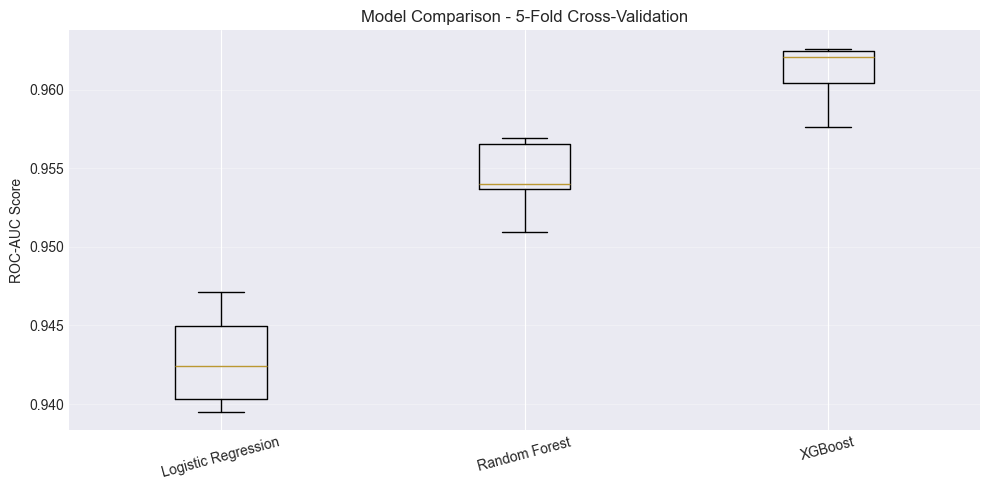


BEST MODEL: XGBoost
ROC-AUC: 0.9610 (+/- 0.0019)



In [388]:
# Visualize comparison
if EDA:
    fig, ax = plt.subplots(figsize=(10, 5))
    positions = range(1, len(cv_results) + 1)
    ax.boxplot(cv_results.values(), positions=positions, labels=cv_results.keys())
    ax.set_ylabel('ROC-AUC Score')
    ax.set_title('Model Comparison - 5-Fold Cross-Validation')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# Select best model
best_model_name = max(cv_results, key=lambda x: cv_results[x].mean())
best_score = cv_results[best_model_name].mean()
best_std = cv_results[best_model_name].std()

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"ROC-AUC: {best_score:.4f} (+/- {best_std:.4f})")
print(f"{'='*60}\n")


### 6.4 Train Final Model


✓ Final model trained: XGBoost
✓ Model saved to final_model.pkl

Top 20 Most Important Features:
                   feature  importance
    avg_diagnosis_severity    0.284732
        INSURANCE_Medicare    0.040607
    max_diagnosis_severity    0.035323
                       AGE    0.028847
                  SpO2_Min    0.026578
RELIGION_PROTESTANT QUAKER    0.020777
                TempC_Mean    0.019887
  MARITAL_STATUS_SEPARATED    0.018576
           diagnosis_count    0.018523
                 SpO2_Mean    0.018219
     RELIGION_UNOBTAINABLE    0.016956
      FIRST_CAREUNIT_TSICU    0.016181
                MeanBP_Min    0.016033
primary_diagnosis_severity    0.015587
                 SysBP_Min    0.015222
               MeanBP_Mean    0.014749
         INSURANCE_Private    0.014041
             RespRate_Mean    0.013712
              Glucose_Mean    0.013085
                SysBP_Mean    0.012726


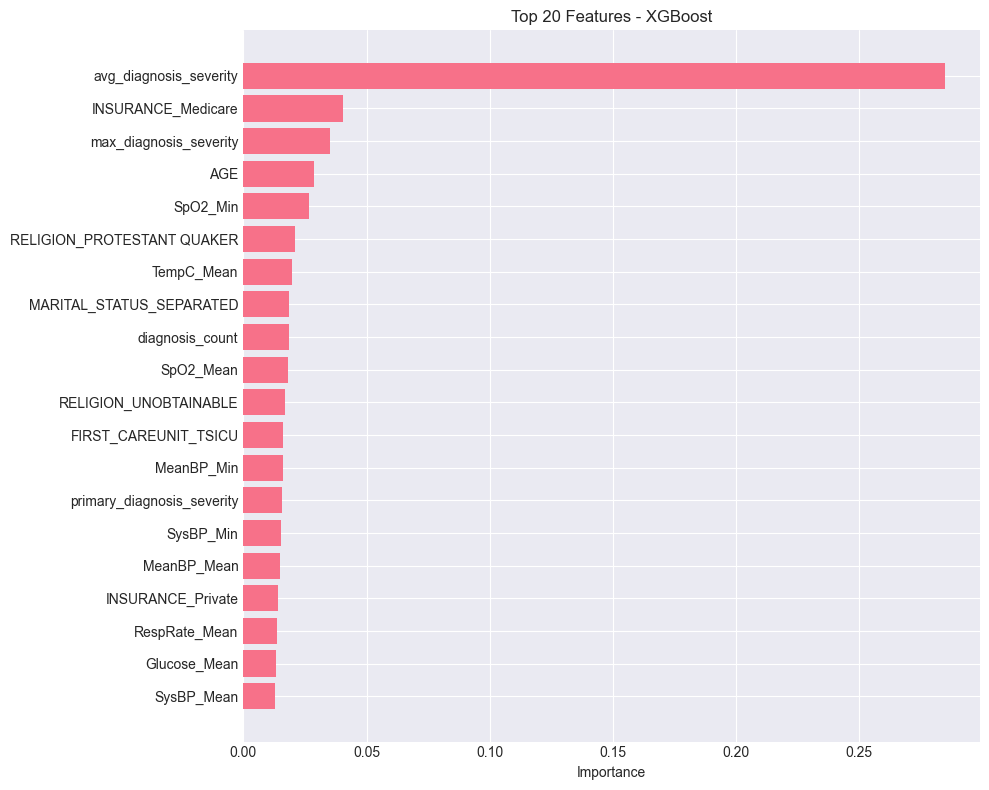

In [389]:
# Train final model on full training set
final_model = models[best_model_name]
final_model.fit(X_train, y_train)

print(f"✓ Final model trained: {best_model_name}")

# Save model
joblib.dump(final_model, 'final_model.pkl')
print("✓ Model saved to final_model.pkl")

# Feature importance (if available)
if hasattr(final_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)
    
    print(f"\nTop 20 Most Important Features:")
    print(importance_df.to_string(index=False))
    
    if EDA:
        plt.figure(figsize=(10, 8))
        plt.barh(importance_df['feature'], importance_df['importance'])
        plt.xlabel('Importance')
        plt.title(f'Top 20 Features - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
elif hasattr(final_model, 'coef_'):
    coef_df = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': final_model.coef_[0]
    })
    coef_df['abs_coef'] = np.abs(coef_df['coefficient'])
    coef_df = coef_df.sort_values('abs_coef', ascending=False).head(20)
    
    print(f"\nTop 20 Features by Absolute Coefficient:")
    print(coef_df[['feature', 'coefficient']].to_string(index=False))


## 7. Final Predictions & CSV Export


### 7.1 Prepare Test Data


In [390]:
# Function to apply preprocessing to test set
def apply_preprocessing_pipeline(df, state):
    """Apply fitted preprocessing to test data"""
    df = df.copy()
    
    print("=== APPLYING PREPROCESSING TO TEST SET ===\n")
    
    # Drop same columns as training
    cols_to_drop = id_cols + leaky_cols + ['DOB', 'ADMITTIME', 'DISCHTIME', 'Diff',
                                           'DIAGNOSIS', 'ICD9_diagnosis']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')
    
    # Remove target if present
    if target_col in df.columns:
        df = df.drop(columns=[target_col])
    
    # Identify feature types
    cat_cols = state['cat_cols']
    vital_cols_in_X = state['vital_cols']
    
    # Get numeric columns (those not in cat_cols)
    num_cols = [c for c in df.columns if c not in cat_cols]
    other_num_cols = [c for c in num_cols if c not in vital_cols_in_X]
    
    # Impute
    if vital_cols_in_X:
        df[vital_cols_in_X] = state['imputer_vitals'].transform(df[vital_cols_in_X])
    if other_num_cols:
        df[other_num_cols] = df[other_num_cols].fillna(df[other_num_cols].median())
    if cat_cols:
        df[cat_cols] = state['imputer_cats'].transform(df[cat_cols])
    
    print("✓ Imputed missing values")
    
    # One-hot encode
    if cat_cols:
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)
        print("✓ Encoded categorical variables")
    
    # Align columns with training
    missing_cols = set(state['feature_columns']) - set(df.columns)
    for col in missing_cols:
        df[col] = 0
    
    extra_cols = set(df.columns) - set(state['feature_columns'])
    df = df.drop(columns=list(extra_cols))
    
    # Reorder to match training
    df = df[state['feature_columns']]
    
    print(f"✓ Aligned columns (added {len(missing_cols)}, removed {len(extra_cols)})")
    
    # Scale
    num_to_scale = [c for c in state['num_to_scale'] if c in df.columns]
    df[num_to_scale] = state['scaler'].transform(df[num_to_scale])
    print(f"✓ Scaled {len(num_to_scale)} features")
    
    print(f"\n✓ TEST PREPROCESSING COMPLETE")
    print(f"  Final shape: {df.shape}")
    
    return df

print("✓ Test preprocessing function defined")


✓ Test preprocessing function defined


In [391]:
# Load and prepare test data
print("=== PREPARING TEST DATA FOR PREDICTIONS ===\n")

# Load fresh test data
test = pd.read_csv('MIMIC III dataset HEF/mimic_test_HEF.csv')
test_ids = test['icustay_id'].copy()  # Save IDs for submission

print(f"Original test shape: {test.shape}")

# Clean test data (drop rows with extreme missingness)
# test_clean = test.dropna(subset=vital_cols_wo_glucose, thresh=1)
# print(f"After cleaning: {test_clean.shape}")

# Add age features
test_with_age = add_age_and_time_features(test)
print("✓ Age features added")

# Add diagnosis features
test_with_diag = apply_diagnosis_features(test_with_age, MIMIC_diagnoses, diag_state)
print("✓ Diagnosis features added")

# Apply preprocessing pipeline
X_test = apply_preprocessing_pipeline(test_with_diag, preprocess_state)

# Verify shape matches training
print(f"\n{'='*60}")
print(f"VERIFICATION:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape:  {X_test.shape}")
print(f"  Shapes match: {X_test.shape[1] == X_train.shape[1]}")
print(f"  Missing values: {X_test.isnull().sum().sum()}")
print(f"{'='*60}\n")

# Update test_ids to match cleaned data
test_ids_clean = test_with_diag['icustay_id'].values


=== PREPARING TEST DATA FOR PREDICTIONS ===

Original test shape: (5221, 39)
✓ Age features added
✓ Diagnosis features added
=== APPLYING PREPROCESSING TO TEST SET ===

✓ Imputed missing values
✓ Encoded categorical variables
✓ Aligned columns (added 5, removed 0)
✓ Scaled 103 features

✓ TEST PREPROCESSING COMPLETE
  Final shape: (5221, 105)

VERIFICATION:
  X_train shape: (21006, 105)
  X_test shape:  (5221, 105)
  Shapes match: True
  Missing values: 0



### 7.2 Generate Predictions


=== PREDICTIONS GENERATED ===
Number of predictions: 5221

Prediction statistics:
  Min:    0.000406
  Max:    0.998255
  Mean:   0.196924
  Median: 0.029576
  Std:    0.301565


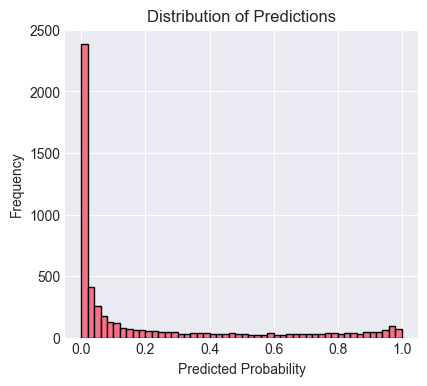

In [392]:
# Generate probability predictions
predictions = final_model.predict_proba(X_test)[:, 1]

print("=== PREDICTIONS GENERATED ===")
print(f"Number of predictions: {len(predictions)}")
print(f"\nPrediction statistics:")
print(f"  Min:    {predictions.min():.6f}")
print(f"  Max:    {predictions.max():.6f}")
print(f"  Mean:   {predictions.mean():.6f}")
print(f"  Median: {np.median(predictions):.6f}")
print(f"  Std:    {predictions.std():.6f}")

# Check distribution
if EDA:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(predictions, bins=50, edgecolor='black')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predictions')
    



### 7.3 Export Submission CSV


In [393]:
# Create submission dataframe
submission = pd.DataFrame({
    'icustay_id': test_ids_clean,
    'prediction': predictions
})

# Export to CSV with version control
from datetime import datetime
import os

# Create timestamped filename
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
base_filename = 'argote_mariajose_CML_2025'
versioned_filename = f'{base_filename}_{timestamp}.csv'
default_filename = f'{base_filename}.csv'

# Save both versioned and latest
submission.to_csv(versioned_filename, index=False)
submission.to_csv(default_filename, index=False)

print("=== SUBMISSION FILE CREATED ===")
print(f"\nTimestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Versioned file: {versioned_filename}")
print(f"Latest file: {default_filename}")
print(f"\nFirst 10 rows:")
print(submission.head(10))

# Log hyperparameters and model info
log_entry = f"""
{'='*60}
SUBMISSION LOG - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*60}
Model: {best_model_name}
CV ROC-AUC: {best_score:.4f} ± {best_std:.4f}
Timestamp: {timestamp}
Versioned File: {versioned_filename}
Predictions: {len(submission)} rows
Min Prob: {predictions.min():.6f}
Max Prob: {predictions.max():.6f}
Mean Prob: {predictions.mean():.6f}
{'='*60}
"""

# Append to log file
with open('submission_log.txt', 'a') as log_file:
    log_file.write(log_entry)

print("\n✓ Log entry saved to submission_log.txt")

print(f"\nFinal verification:")
print(f"  Rows: {len(submission)}")
print(f"  Columns: {submission.columns.tolist()}")
print(f"  Missing values: {submission.isnull().sum().sum()}")
print(f"  Prediction range: [{predictions.min():.6f}, {predictions.max():.6f}]")
print(f"  All predictions between 0-1: {(predictions >= 0).all() and (predictions <= 1).all()}")


print("✅ woooooooooo! Predictions exported to CSV")



=== SUBMISSION FILE CREATED ===

Timestamp: 2025-12-10 21:28:28
Versioned file: argote_mariajose_CML_2025_20251210_212828.csv
Latest file: argote_mariajose_CML_2025.csv

First 10 rows:
   icustay_id  prediction
0      208169    0.003431
1      251754    0.491442
2      242171    0.042536
3      263035    0.026800
4      279388    0.057106
5      262988    0.353888
6      291777    0.004083
7      217458    0.004765
8      283955    0.089783
9      287227    0.002146

✓ Log entry saved to submission_log.txt

Final verification:
  Rows: 5221
  Columns: ['icustay_id', 'prediction']
  Missing values: 0
  Prediction range: [0.000406, 0.998255]
  All predictions between 0-1: True
✅ woooooooooo! Predictions exported to CSV
